<a href="https://colab.research.google.com/github/yezzzzin/LIEON_preprocessing/blob/main/labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyannote.audio
!pip install huggingface-hub

In [3]:
import os
from pyannote.audio import Pipeline, Audio
from pyannote.core import Segment
import csv

In [4]:
# Hugging Face API 토큰
use_auth_token = "hf"

# 환경 변수로 토큰 설정
os.environ["HUGGINGFACEHUB_API_TOKEN"] = use_auth_token

In [5]:
# 사전 학습된 음성 분할 파이프라인 로드
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=use_auth_token)

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [6]:
# 음성 파일 경로
audio_file = "/content/drive/MyDrive/보이스피싱 실제 통화내용_[cut_39sec].wav"

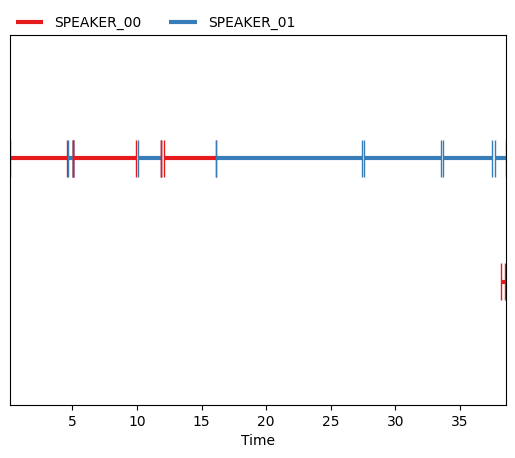

In [7]:
# 음성 파일 처리
if pipeline is not None:
    diarization = pipeline(audio_file, num_speakers=2)

    # 라벨링 결과 출력 및 CSV 파일 저장
    label_mapping = {}
    label_counter = 0

    # CSV 파일 경로
    # CSV 파일 경로
    output_csv_file = "/content/drive/MyDrive/labeled_segments.csv"

    # CSV 파일이 저장될 디렉토리 경로
    output_directory = os.path.dirname(output_csv_file)

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # CSV 파일 열기 및 헤더 작성
    with open(output_csv_file, 'w', newline='') as csvfile:
        fieldnames = ['Start', 'End', 'Speaker', 'Label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()

        # 라벨링 결과 작성
        for turn, _, speaker in diarization.itertracks(yield_label=True):
            if speaker not in label_mapping:
                label_mapping[speaker] = label_counter
                label_counter += 1
            label = label_mapping[speaker]
            writer.writerow({'Start': turn.start, 'End': turn.end, 'Speaker': speaker, 'Label': label})

    # 시각화
    import matplotlib.pyplot as plt
    from pyannote.core import notebook
    %matplotlib inline
    fig, ax = plt.subplots()
    notebook.plot_annotation(diarization, ax=ax, time=True)
    plt.show()
else:
    print("Failed to load the pre-trained model.")